In [1]:
import glob
import sys

import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, XGBRFClassifier

sys.path.append("../../../")

from helpers.experiment import experiment
from helpers.split import tag_label_feature_split

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index




Commencing Experiment: XGBRFClassifier_dataset_00_all

PCA pre_processing started
PCA pre_processing completed
[23:16:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.631674

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.8278  0.8552    0.8413     4221  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

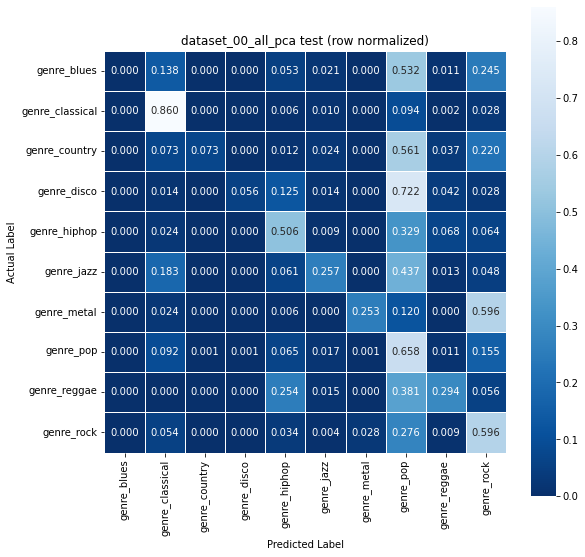



Commencing Experiment: XGBRFClassifier_dataset_01_mean

PCA pre_processing started
PCA pre_processing completed
[23:17:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.523185

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7175  0.8612    0.7828     4221 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

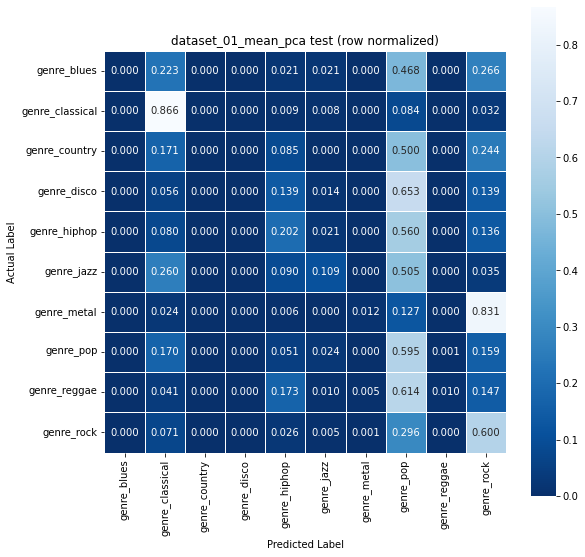



Commencing Experiment: XGBRFClassifier_dataset_02_mean_cov

PCA pre_processing started
PCA pre_processing completed
[23:17:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.556850

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7194  0.8285    0.7701     4

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

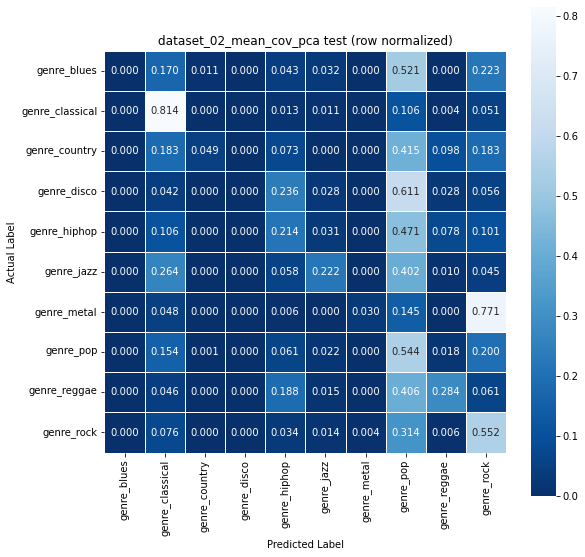



Commencing Experiment: XGBRFClassifier_dataset_03_mean_icov

PCA pre_processing started
PCA pre_processing completed
[23:17:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.474532

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.6656  0.7456    0.7033     

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

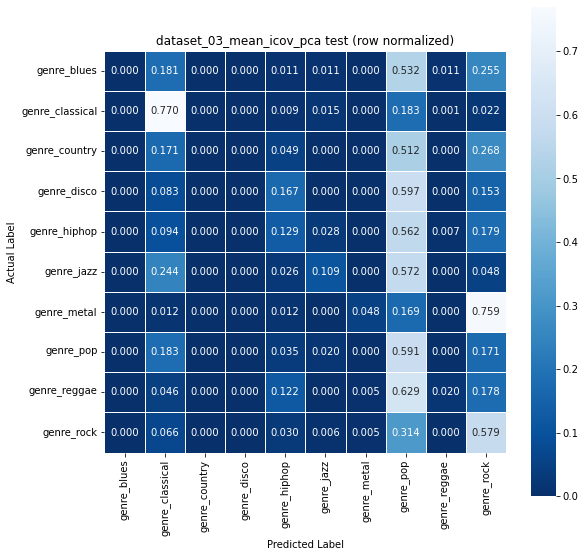



Commencing Experiment: XGBRFClassifier_dataset_04_mean_cov_icov

PCA pre_processing started
PCA pre_processing completed
[23:17:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.553689

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support      mcc
                                                                
      genre_blues     0.0000  0.0000    0.0000      374   0.0000
  genre_classical     0.7171  0.8249    0.76

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

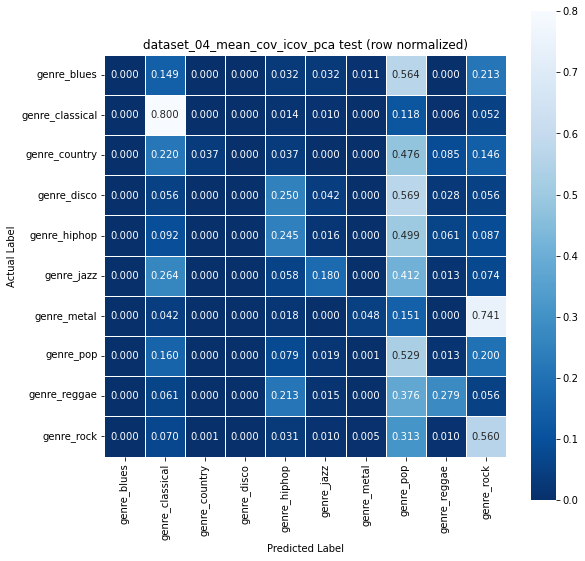



Commencing Experiment: XGBRFClassifier_dataset_05_pvtt

PCA pre_processing started
PCA pre_processing completed
[23:17:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.521956

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.8007  0.8574    0.8281     4221 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

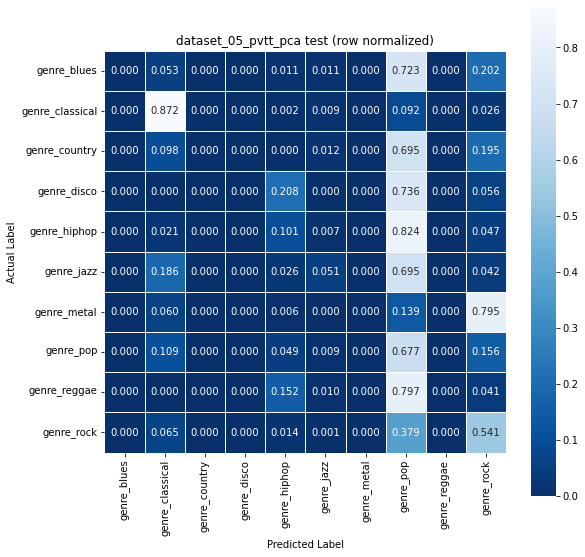



Commencing Experiment: XGBRFClassifier_dataset_06_pvtt_mean

PCA pre_processing started
PCA pre_processing completed
[23:17:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.548653

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7954  0.8666    0.8295     

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

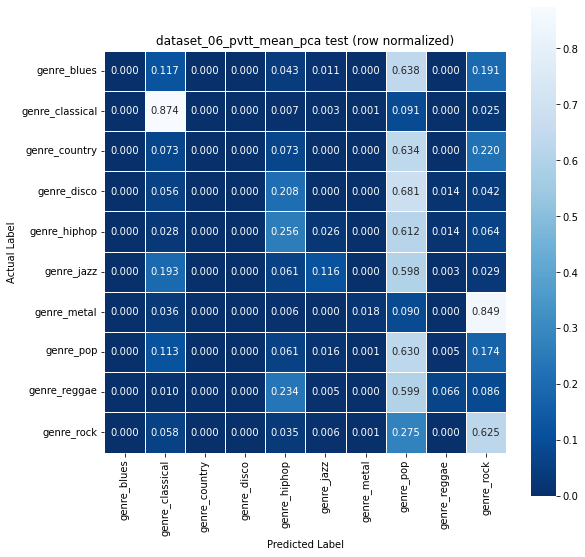



Commencing Experiment: XGBRFClassifier_dataset_07_pvtt_mean_cov

PCA pre_processing started
PCA pre_processing completed
[23:17:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.562763

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7320  0.8555    0.7889 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

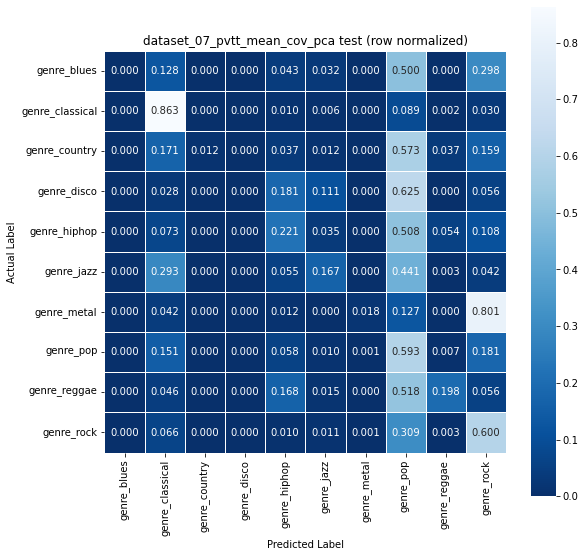



Commencing Experiment: XGBRFClassifier_dataset_08_pvtt_mean_icov

PCA pre_processing started
PCA pre_processing completed
[23:17:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.535187

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7924  0.8664    0.8278

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

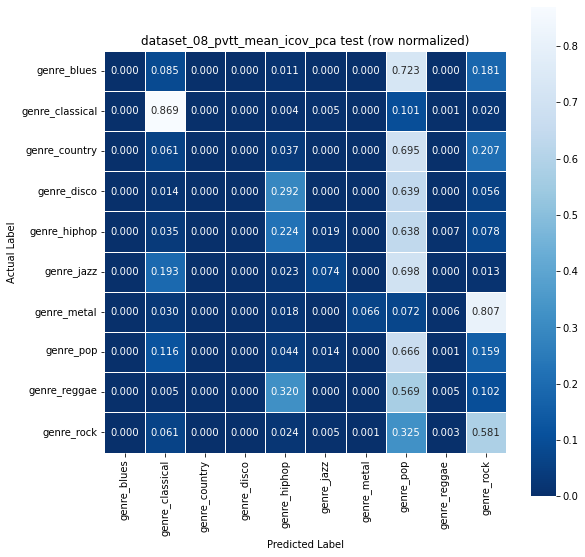



Commencing Experiment: XGBRFClassifier_dataset_09_pvtt_mean_cov_icov

PCA pre_processing started
PCA pre_processing completed
[23:17:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.566920

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.7619  0.8349    0.

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

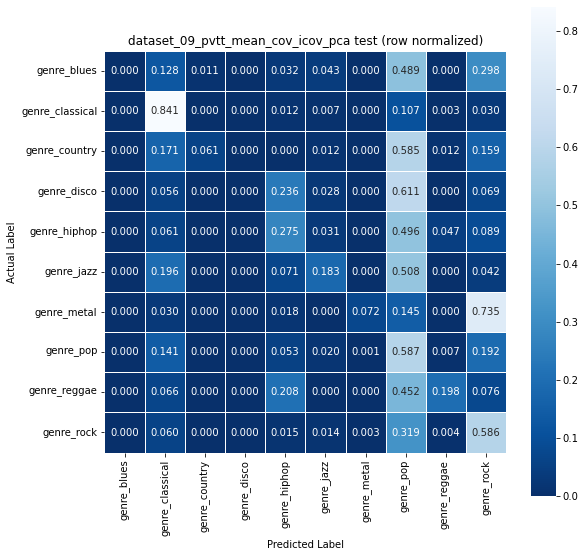



Commencing Experiment: XGBRFClassifier_dataset_10_melspectrograms_flattened

PCA pre_processing started
PCA pre_processing completed
[23:19:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117836726/work/src/learner.cc:576: 
Parameters: { "sample_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy: train_accuracy = 0.522365

/home/jovyan/github/mids-w207/mids_w207_music_genre/member_workspaces/rich/models/../../../results/rich_results.json
file exist, reading json
record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000      374  0.0000
  genre_classical     0.6978  0.813

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

record saved
                   precision  recall  f1-score  support     mcc
                                                               
      genre_blues     0.0000  0.0000    0.0000       94  0.0000
  genre_classical     0.6942  0.8114    0.7483     1055  0.6606
    genre_country     0.0000  0.0000    0.0000       82  0.0000
      genre_disco     0.0000  0.0000    0.0000       72  0.0000
     genre_hiphop     0.4431  0.1741    0.2500      425  0.2316
       genre_jazz     0.4211  0.1029    0.1654      311  0.1804
      genre_metal     0.5000  0.0120    0.0235      166  0.0730
        genre_pop     0.3592  0.6286    0.4571     1069  0.2219
     genre_reggae     1.0000  0.0051    0.0101      197  0.0696
       genre_rock     0.4940  0.5675    0.5282      800  0.4116
                                                               
         accuracy                       0.4896     4271  0.3529
        macro avg     0.3912  0.2302    0.2183     4271        
     weighted avg     0.494

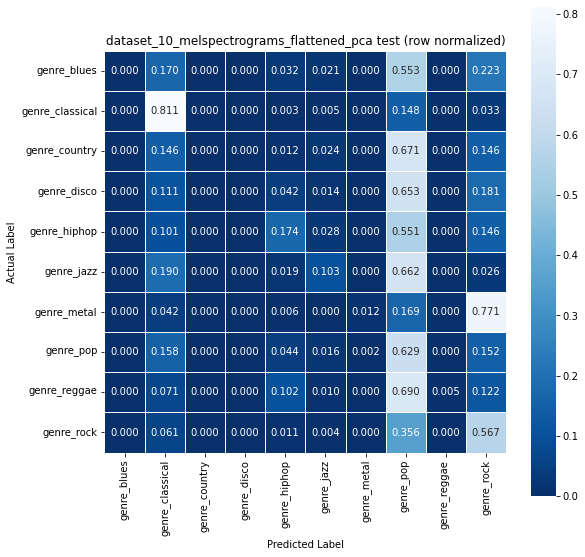

In [2]:
dataset_folder = "../../../datasets/"
datasets = sorted([name for name in glob.glob(dataset_folder + "dataset_*.pickle")])

### For XGBClassifier we need to calculate class weights with sklearn first
### The imbalance in our datasets is the same, so we can pick one of the
### smaller sets (by feature size) to calculate class weights.

df = pd.read_pickle(dataset_folder + "dataset_01_mean.pickle")
_, (y, _), _ = tag_label_feature_split(df, label_format="encoded")
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

for dataset in datasets:
    
    if "spectrogram" in dataset:
        n_components = 2400
    else:
        n_components = .95
        
    model = XGBRFClassifier(        
        use_label_encoder=False, 
        tree_method='gpu_hist', 
        objective="multi:softprob", 
        eval_metric="mlogloss",
        sample_weight=class_weights,
        eta=.05,
        max_depth=6,
        reg_alpha=10,
        sampling_method='gradient_based',
    )
    experiment(
        model, dataset, pca_components=n_components, result_filename="rich_results.json"
    )